<center> <img alt=\"DAGsHub\" width=500px src=https://raw.githubusercontent.com/DAGsHub/client/master/dagshub_github.png> </center>

# SavtaDepth Sanity Check

### ***This notebook is meant to be run on Google Colab*** - [link to a live version](https://colab.research.google.com/drive/1sARthauqgHfKnsQauKU_kr-954XXBN1p)

This notebook is intended as a sanity check and initial end-2-end pipeline for the [SavtaDepth](https://dagshub.com/OperationSavta/SavtaDepth) project which is an Open Source Data Science project. We'd love to get help from the community, so if you'd like to contribute head over to the [project page](https://dagshub.com/OperationSavta/SavtaDepth) to get started.



In [1]:
%reload_ext autoreload
%autoreload 2

# Make Dataset for finetuning

The labeled dataset is approximately ***2.8GB***

In [2]:
# Project Structure
!mkdir workspace
%cd workspace/
!mkdir dataset
# Should use DVC add
!wget http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat
!wget http://horatio.cs.nyu.edu/mit/silberman/indoor_seg_sup/splits.mat

/content/workspace
--2020-08-19 12:35:31--  http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat
Resolving horatio.cs.nyu.edu (horatio.cs.nyu.edu)... 216.165.22.17
Connecting to horatio.cs.nyu.edu (horatio.cs.nyu.edu)|216.165.22.17|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2972037809 (2.8G)
Saving to: ‘nyu_depth_v2_labeled.mat’

nyu_depth_v2_labele 100%[===================>]   2.77G  35.0MB/s    in 83s     

2020-08-19 12:36:54 (34.2 MB/s) - ‘nyu_depth_v2_labeled.mat’ saved [2972037809/2972037809]

--2020-08-19 12:36:55--  http://horatio.cs.nyu.edu/mit/silberman/indoor_seg_sup/splits.mat
Resolving horatio.cs.nyu.edu (horatio.cs.nyu.edu)... 216.165.22.17
Connecting to horatio.cs.nyu.edu (horatio.cs.nyu.edu)|216.165.22.17|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2626 (2.6K)
Saving to: ‘splits.mat’

splits.mat          100%[===================>]   2.56K  --.-KB/s    in 0s      

2020-08-19 12:36:55 (40

In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#######################################################################################
# The MIT License

# Copyright (c) 2014       Hannes Schulz, University of Bonn  <schulz@ais.uni-bonn.de>
# Copyright (c) 2013       Benedikt Waldvogel, University of Bonn <mail@bwaldvogel.de>
# Copyright (c) 2008-2009  Sebastian Nowozin                       <nowozin@gmail.com>

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
# 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
# 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.
#######################################################################################
#
# Helper script to convert the NYU Depth v2 dataset Matlab file into a set of
# PNG and JPEG images.
#
# See https://github.com/deeplearningais/curfil/wiki/Training-and-Prediction-with-the-NYU-Depth-v2-Dataset

from __future__ import print_function

import h5py
import numpy as np
import os
import scipy.io
import sys
import cv2


def convert_image(i, scene, depth, image, folder):
    img_depth = depth * 1000.0
    img_depth_uint16 = img_depth.astype(np.uint16)
    cv2.imwrite("%s/%05d_depth.png" % (folder, i), img_depth_uint16)

    normalized_depth = np.zeros(img_depth_uint16.shape)
    normalized_depth = cv2.normalize(img_depth_uint16, normalized_depth, 0, 255, cv2.NORM_MINMAX)
    cv2.imwrite("%s/%05d_depth_norm.png" % (folder, i), normalized_depth)

    image = image[:, :, ::-1]
    image_black_boundary = np.zeros((480, 640, 3), dtype=np.uint8)
    image_black_boundary[7:474, 7:632, :] = image[7:474, 7:632, :]
    cv2.imwrite("%s/%05d.jpg" % (folder, i), image_black_boundary)


def extract_official_train_test_set(original_mat, splits_mat, data_folder_path):

    h5_file = h5py.File(original_mat, "r")
    # h5py is not able to open that file. but scipy is
    train_test = scipy.io.loadmat(splits_mat)
    out_folder = data_folder_path

    test_images = set([int(x) for x in train_test["testNdxs"]])
    train_images = set([int(x) for x in train_test["trainNdxs"]])
    print("%d training images" % len(train_images))
    print("%d test images" % len(test_images))

    depth = h5_file['depths']

    print("reading", original_mat)

    images = h5_file['images']
    scenes = [u''.join(chr(c) for c in h5_file[obj_ref]) for obj_ref in h5_file['sceneTypes'][0]]

    print("processing images")
    for i, image in enumerate(images):
        print("image", i + 1, "/", len(images))

        idx = int(i) + 1
        if idx in train_images:
            train_test = "train"
        else:
            assert idx in test_images, "index %d neither found in training set nor in test set" % idx
            train_test = "test"

        folder = "%s/%s/%s" % (out_folder, train_test, scenes[i])
        if not os.path.exists(folder):
            os.makedirs(folder)
        convert_image(i, scenes[i], depth[i, :, :].T, image.T, folder)

    print("Finished")

In [4]:
data_path = './dataset/nyu_depth_v2/official_splits'

In [5]:
# Convert Mat to Proper image dataset
extract_official_train_test_set("nyu_depth_v2_labeled.mat", "splits.mat", data_path)

795 training images
654 test images
reading nyu_depth_v2_labeled.mat
processing images
image 1 / 1449
image 2 / 1449
image 3 / 1449
image 4 / 1449
image 5 / 1449
image 6 / 1449
image 7 / 1449
image 8 / 1449
image 9 / 1449
image 10 / 1449
image 11 / 1449
image 12 / 1449
image 13 / 1449
image 14 / 1449
image 15 / 1449
image 16 / 1449
image 17 / 1449
image 18 / 1449
image 19 / 1449
image 20 / 1449
image 21 / 1449
image 22 / 1449
image 23 / 1449
image 24 / 1449
image 25 / 1449
image 26 / 1449
image 27 / 1449
image 28 / 1449
image 29 / 1449
image 30 / 1449
image 31 / 1449
image 32 / 1449
image 33 / 1449
image 34 / 1449
image 35 / 1449
image 36 / 1449
image 37 / 1449
image 38 / 1449
image 39 / 1449
image 40 / 1449
image 41 / 1449
image 42 / 1449
image 43 / 1449
image 44 / 1449
image 45 / 1449
image 46 / 1449
image 47 / 1449
image 48 / 1449
image 49 / 1449
image 50 / 1449
image 51 / 1449
image 52 / 1449
image 53 / 1449
image 54 / 1449
image 55 / 1449
image 56 / 1449
image 57 / 1449
image 58 /

## Prepare Model for Finetuning

In [6]:
from fastai.vision import \
  unet_learner, \
  ImageDataBunch, \
  ImageImageList, \
  models, \
  lr_find, \
  ImageList, \
  Path, \
  Image, \
  root_mean_squared_error, \
  get_transforms
import torch

In [7]:
def get_y_fn(x):
  y = str(x.absolute()).replace('.jpg','_depth_norm.png')
  y = Path(y)

  return y

In [8]:
data_path = Path('./dataset/nyu_depth_v2/official_splits')
data = (ImageImageList.from_folder(data_path)
  .filter_by_func(lambda fname: fname.suffix == '.jpg')
  .split_by_folder(train='train', valid='test')
  .label_from_func(get_y_fn).databunch()).normalize()

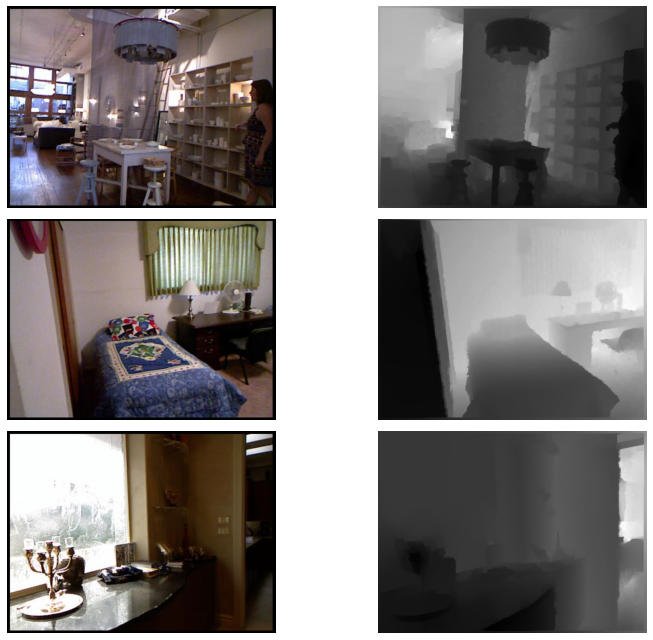

In [9]:
data.show_batch(rows=3, figsize=(12, 9))

## Train U_Net Model

In [10]:
# Check what GPU we have
!nvidia-smi

Wed Aug 19 12:38:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    74W / 149W |   1274MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
(torch.cuda.memory_reserved() - torch.cuda.memory_allocated())/1e6

950.009856

In [12]:
# Initial values batch_size = 64, num_workers = 2
data.batch_size = 2
data.num_workers = 0

In [13]:
learner = unet_learner(data, models.resnet34, metrics=root_mean_squared_error, wd=1e-2, loss_func=torch.nn.SmoothL1Loss())
lr_find(learner)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [14]:
(torch.cuda.memory_reserved() - torch.cuda.memory_allocated())/1e6

4686.146048

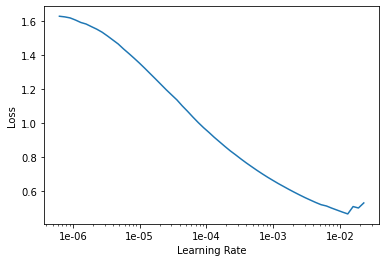

In [16]:
learner.recorder.plot()

### Train Model

In [17]:
learner.fit_one_cycle(1,1e-3)
learner.save('baseline')

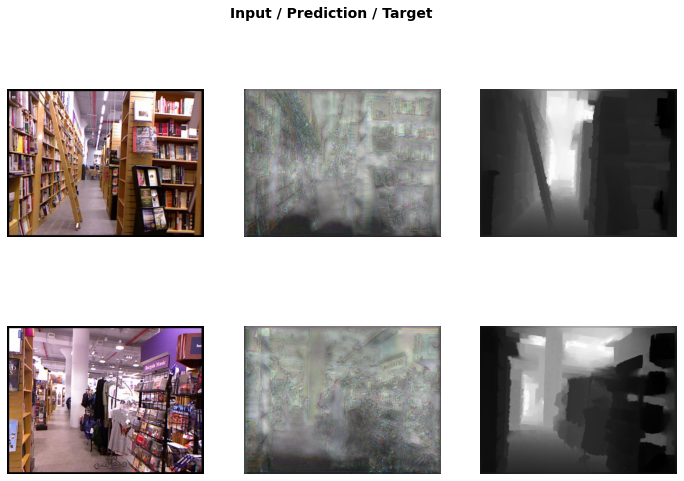

In [18]:
learner.show_results()

### Load Existing model

In [ ]:
learner = learner.load("/content/workspace/dataset/nyu_depth_v2/official_splits/models/baseline")

## Predict on Image

mkdir: cannot create directory ‘images’: File exists
/content/workspace/images


Saving guy.jpg to guy.jpg
/content/workspace


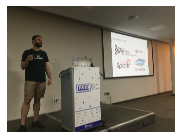

In [35]:
!mkdir images
%cd images

from google.colab import files
from io import BytesIO
from fastai.vision import open_image
import matplotlib.pyplot as plt
import numpy as np

# Upload Image
uploaded = files.upload()
original = open_image(BytesIO(uploaded[list(uploaded.keys())[0]]))

# Preview original image
original.show()

%cd ../

In [36]:
original_shape = (original.shape[1],original.shape[2])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


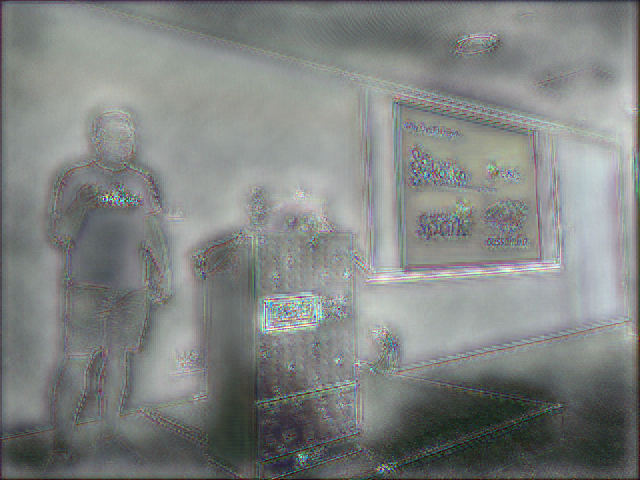

In [37]:
minified = original.resize((3,480,640))
predicted_depth_map = learner.predict(minified)
predicted_depth_map[0].save('images/guy_depth.jpg')
predicted_depth_map[0]

In [38]:
from PIL import Image as PILImage
output = PILImage.open('images/guy_depth.jpg')
output = output.resize(original_shape)
output.save('images/guy_depth.jpg')

# Cleanup code

In [ ]:
import gc
del learner
del data
torch.cuda.empty_cache()
gc.collect()